In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from random import sample

In [2]:
def run_independent_set(neighbor_lambda, input_G, tau_number, tau_mut, tau_degree, seed = None, debug=False, random_start = True):
    """
    Helper function to generate SPECTRA splits using approximation of independent set algorithm
    """
    total_deleted = 0
    
    if seed is not None:
        random.seed(seed)
    
    G = input_G.copy()

    independent_set = []
    
    iterations = 0
    
    while not nx.is_empty(G):
        if not random_start:
            chosen_node = max(node_to_score, key=node_to_score.get)
        else:
            chosen_node = sample(list(G.nodes()), 1)[0]
        
        independent_set.append(chosen_node)
        neighbors = G.neighbors(chosen_node)
        neighbors_to_delete = []
        
        for neighbor in neighbors:
            if neighbor_lambda == 1.0:
                neighbors_to_delete.append(neighbor)
            elif neighbor_lambda != 0.0:
                if random.random() < neighbor_lambda:
                    neighbors_to_delete.append(neighbor)

        if debug:
            print(f"Iteration {iterations} Stats")
            print(f"Deleted {len(neighbors_to_delete)} nodes")

        for neighbor in neighbors_to_delete:
            G.remove_node(neighbor)
        
        if chosen_node not in neighbors_to_delete:
            G.remove_node(chosen_node)
    
        iterations += 1
    
    independent_set.append('NO_MUTATION')
    if debug:
        print(f"Total deleted {total_deleted}")
    return independent_set

# Constructing spectral property graph

In [3]:
G = nx.Graph()

In [4]:
count_to_name = {}
name_to_count = {}
counts_to_similarity = {}
# total_similarities = []


count = 0

counter = 0
for line in open('localization_sequences_comparison', 'r'):
    data = line.split('\t')
    
    one = data[0]
    if one not in name_to_count:
        count_to_name[count] = one
        name_to_count[one] = count
        G.add_node(count)
        count += 1

    two = data[1]
    if two not in name_to_count:
        count_to_name[count] = two
        name_to_count[two] = count
        G.add_node(count)
        count += 1
    
    similarities = float(data[2])
    if similarities > 0.3:
        G.add_edge(name_to_count[one], name_to_count[two], similarity = similarities)
    counts_to_similarity[f'{name_to_count[one]}-{name_to_count[two]}'] = similarities
    counter += 1

In [6]:
import pickle
pickle.dump(counts_to_similarity, open('counts_to_similarity', 'wb'))

In [3]:
import pickle
counts_to_similarity = pickle.load(open('counts_to_similarity', 'rb'))

In [6]:
nx.write_gexf(G, "not_annotated_localization.gexf")

In [2]:
G = nx.read_gexf('not_annotated_localization.gexf')

In [3]:
print(G.number_of_nodes())
print(G.number_of_edges())
print(nx.number_connected_components(G))

13949
55130
7557


# Generating SPECTRA splits

In [11]:
def calculate_proportion(x_train, x_test):
    over_thirty = 0

    for i in x_train:
        for j in x_test:
            if f'{i}-{j}' in counts_to_similarity:
                resultat = counts_to_similarity[f'{i}-{j}']
                if resultat > 0.3:
                    over_thirty += 1
                    break
    
    return over_thirty/len(x_train)
    

In [12]:
calculated_proportions = []
lambda_params = []
number_samples = []

for lambda_param in np.arange(0, 1.05, 0.025):
    lambda_params.append(lambda_param)
    result = run_independent_set(lambda_param, G, 0, 0, 0)
    x_train ,x_test = train_test_split(result,test_size=0.2) 
    calculated_proportions.append(calculate_proportion(x_train, x_test))
    number_samples.append(len(result))
    

In [13]:
pickle.dump(calculated_proportions, open('calc_prop', 'wb'))
pickle.dump(lambda_params, open('lambda_params', 'wb'))
pickle.dump(number_samples, open('number_samples', 'wb'))

# SPECTRA split stats

In [2]:
import matplotlib.pyplot as plt
import pickle

calculated_proportions = pickle.load(open('calc_prop', 'rb'))
lambda_params = pickle.load(open('lambda_params', 'rb'))
number_samples = pickle.load(open('number_samples', 'rb'))

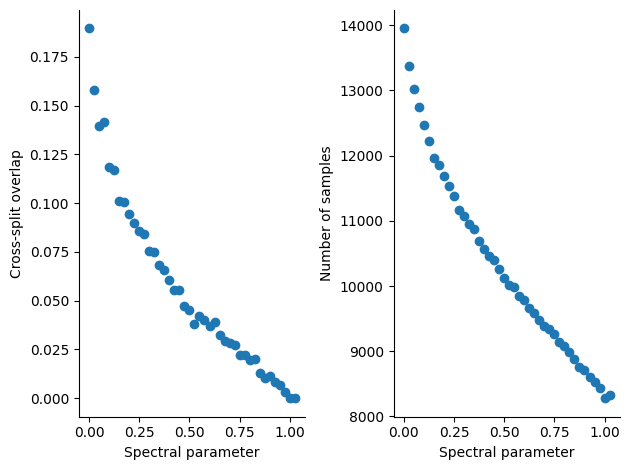

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.scatter(lambda_params, calculated_proportions)
ax1.set_ylabel('Cross-split overlap')
ax1.set_xlabel('Spectral parameter')
ax1.spines[['right', 'top']].set_visible(False)
ax2.scatter(lambda_params, number_samples)
ax2.set_ylabel('Number of samples')
ax2.set_xlabel('Spectral parameter')
ax2.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig('PEER_Localization_Spectra_Stats.pdf')

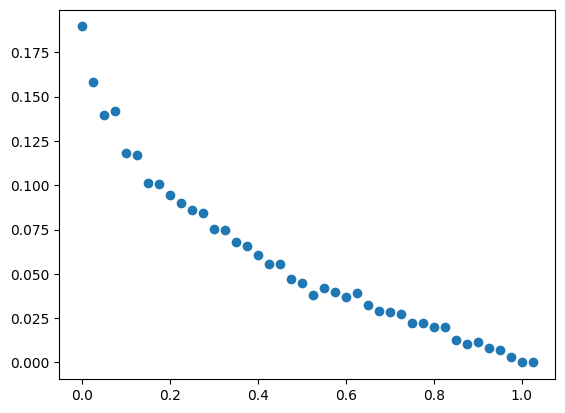

In [14]:
plt.scatter(lambda_params, calculated_proportions)

In [54]:
def find_closest(overlap, x, y):
    min_difference = 1000000
    best_overlap = None
    best_param = None
    
    
    for i,j in zip(x, y):
        if abs(overlap - j) < min_difference:
            best_param = i
            best_overlap = j
            min_difference = abs(overlap - j)
    
    print(f"{best_overlap} and {best_param} for {overlap}")

In [56]:
find_closest(0.2515328019619865, lambda_params, calculated_proportions)

0.2555724644167935 and 0.05 for 0.2515328019619865


# Calculate overlap in existing splits

In [16]:
train_counts = [name_to_count[i.rstrip()] for i in open('localization_train', 'r') if i.rstrip() in name_to_count]
test_counts = [name_to_count[i.rstrip()] for i in open('localization_test', 'r') if i.rstrip() in name_to_count]

In [18]:
def find_closest(overlap, x, y):
    min_difference = 1000000
    best_overlap = None
    best_param = None
    
    
    for i,j in zip(x, y):
        if abs(overlap - j) < min_difference:
            best_param = i
            best_overlap = j
            min_difference = abs(overlap - j)
    
    print(f"{best_overlap} and {best_param} for {overlap}")

In [19]:
t = calculate_proportion(train_counts, test_counts)
print(t)
find_closest(t, lambda_params, calculated_proportions)

0.06766984240049861
0.06611475221340692 and 0.325 for 0.06766984240049861
